## Import Libraries

In [1]:
import cv2                 
import numpy as np         
import os      
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

import glob as gb


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.utils import to_categorical

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
%matplotlib inline

## Define Constant

In [2]:
# Total number of images we want to have in each class
NUM_AUG_IMAGES_WANTED = 1000

# We will resize the images
IMAGE_HEIGHT= 128
IMAGE_WIDTH = 128

## Define Image Directories

In [3]:
#read DataSet
shen_folder="D:\MLWorkSpaces\Deep Learning\Datasets\CNN\ChestTB01N\ChinaSet_AllFiles\CXR_png"
mont_folder="D:\MLWorkSpaces\Deep Learning\Datasets\CNN\ChestTB01N\MontgomerySet\CXR_png"


print(shen_folder)
print(mont_folder)

D:\MLWorkSpaces\Deep Learning\Datasets\CNN\ChestTB01N\ChinaSet_AllFiles\CXR_png
D:\MLWorkSpaces\Deep Learning\Datasets\CNN\ChestTB01N\MontgomerySet\CXR_png


In [4]:
#shen_image_list = gb.glob(shen_folder + '/*.png')
#mont_image_list = gb.glob(mont_folder + '/*.png')

shen_image_list = os.listdir(shen_folder )
mont_image_list = os.listdir(mont_folder )

## Put Image to Pandas Dataframe

In [5]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)


In [6]:
df_mont.head()

,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


In [7]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [8]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)
df_mont['target'] = df_mont['image_id'].apply(extract_target)

## Explore Images

In [9]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + '/' + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()

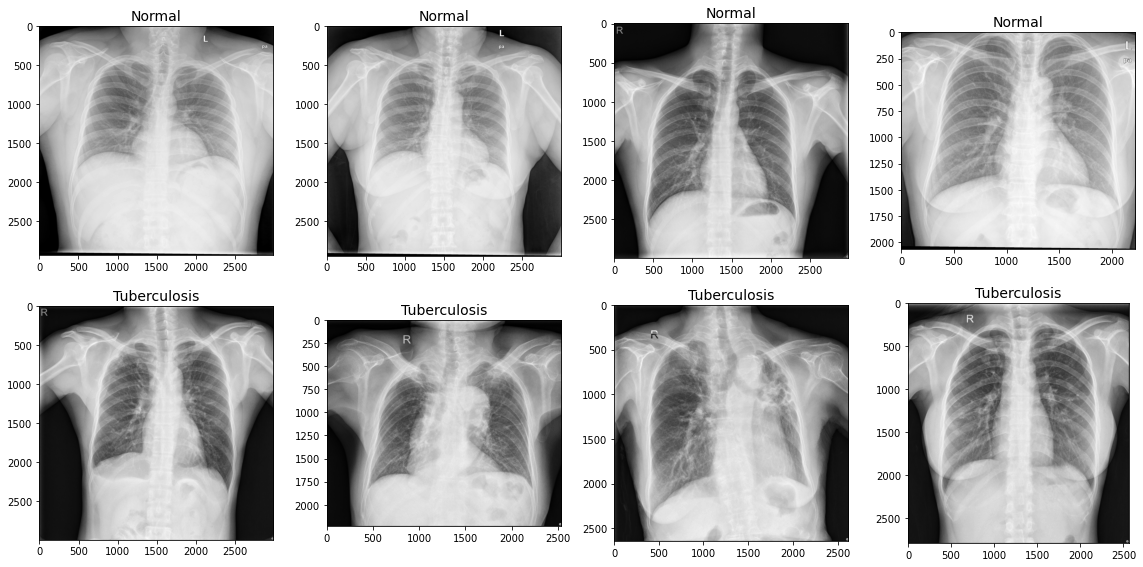

In [10]:
draw_category_images('target',4, df_shen, shen_folder)

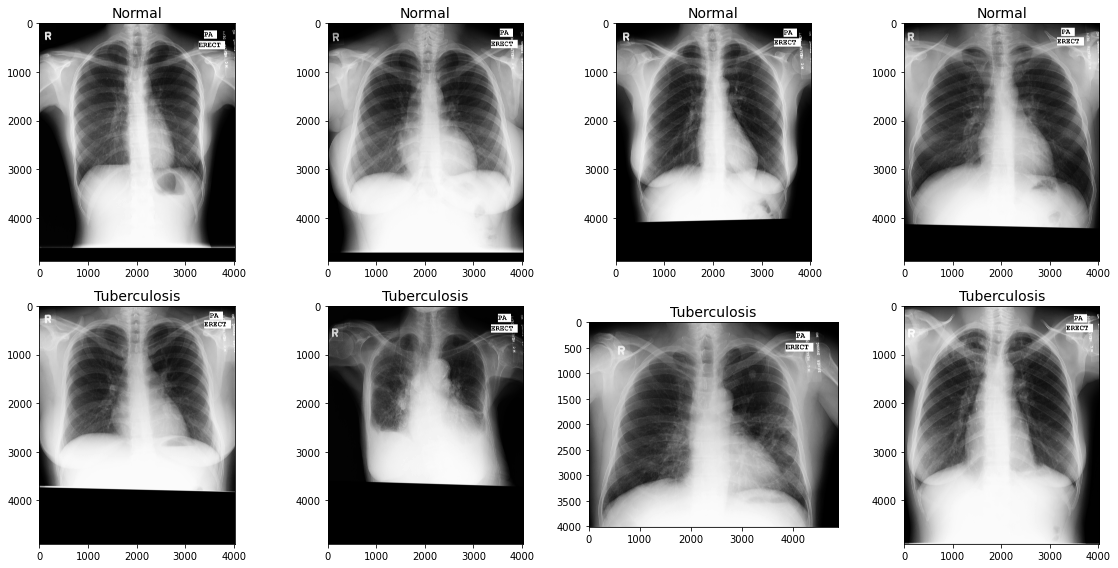

In [11]:
draw_category_images('target',4, df_mont, mont_folder)

## Check Images Shape

In [13]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    if file_name[:3] == 'CHN' :
        IMAGE_PATH = shen_folder + '/'
    else:
        IMAGE_PATH = mont_folder + '/'
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [14]:
m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
2,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0
3,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
4,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0


In [15]:
m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


## Setting Train and Test Set

In [16]:
### Combine the two dataframes

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

df_data.shape

(800, 7)

In [17]:
# Create a new column called 'results' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [21]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
79,CHNCXR_0080_0.png,Normal,2955,3000,3,255,0,0
335,CHNCXR_0336_1.png,Tuberculosis,2742,2472,3,255,0,1
655,CHNCXR_0656_1.png,Tuberculosis,2988,3001,3,255,0,1
82,CHNCXR_0083_0.png,Normal,2947,3000,3,255,0,0
538,CHNCXR_0539_1.png,Tuberculosis,2905,2520,3,255,0,1


In [22]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [23]:
df_train['labels'].value_counts()

0    345
1    335
Name: labels, dtype: int64

In [24]:
df_val['labels'].value_counts()

0    61
1    59
Name: labels, dtype: int64

## Create Folder for Augmentation

In [25]:
# Create a new directory
base_dir = 'D:/MLWorkspaces/Deep Learning/base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

In [26]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [27]:
# Get a list of images in each of the two folders
folder_1 = os.listdir(shen_folder)
folder_2 = os.listdir(mont_folder)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


In [28]:
# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(shen_folder, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(mont_folder, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [29]:
# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(shen_folder, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(mont_folder, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [30]:
# check how many train images we have in each folder

print(len(os.listdir(train_dir + '/Normal')))
print(len(os.listdir(train_dir + '/Tuberculosis')))

345
335


In [31]:
# check how many train images we have in each folder

print(len(os.listdir(val_dir + '/Normal')))
print(len(os.listdir(val_dir + '/Tuberculosis')))

61
59


## Image Augmentation

In [32]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later.
    # create a base dir
    aug_dir ='D:/MLWorkspaces/Deep Learning/aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir(train_dir + '/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join(train_dir + '/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = train_dir + '/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree(aug_dir)

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [33]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir(train_dir + '/Normal')))
print(len(os.listdir(train_dir + '/Tuberculosis')))

1035
1005


In [34]:
print(NUM_AUG_IMAGES_WANTED)

1000


In [35]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir(val_dir + '/Normal')))
print(len(os.listdir(val_dir + '/Tuberculosis')))

61
59


## Explore Augmented Image

In [36]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

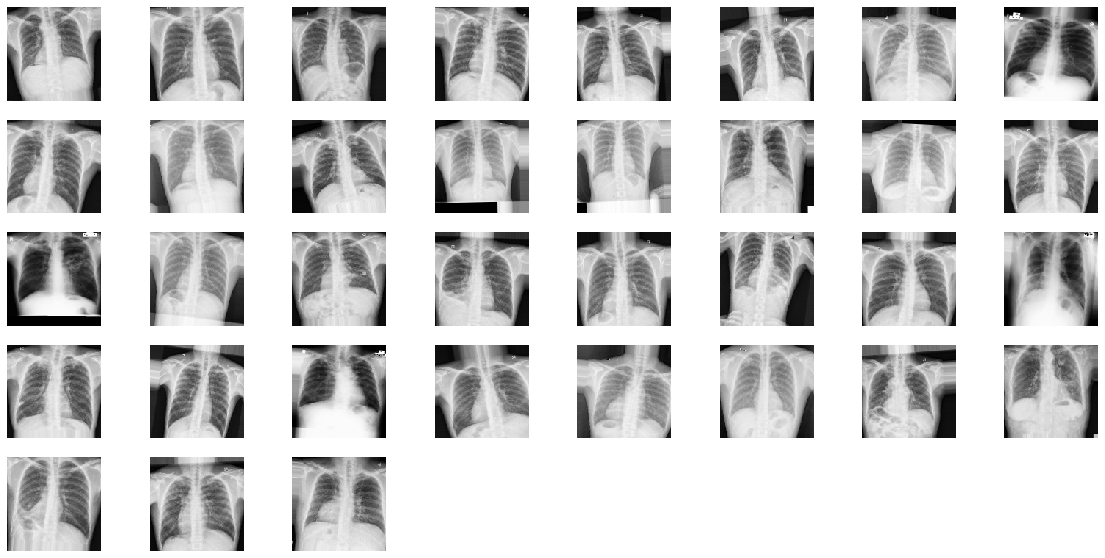

In [37]:
plots(imgs, titles=None) # titles=labels will display the image labels

## Modeling

In [38]:
train_path = train_dir
valid_path = val_dir

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print(train_steps)
print(val_steps)

68.0
12.0


In [39]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2040 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


## First Model Architecture

In [40]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 64)        3

In [41]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/100
68/68 [==============================] - 6s 28ms/step - loss: 0.6952 - accuracy: 0.4784 - val_loss: 0.6928 - val_accuracy: 0.4917

Epoch 00001: val_accuracy improved from -inf to 0.49167, saving model to model.h5
Epoch 2/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6917 - accuracy: 0.5590 - val_loss: 0.6922 - val_accuracy: 0.4917

Epoch 00002: val_accuracy did not improve from 0.49167
Epoch 3/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6900 - accuracy: 0.5562 - val_loss: 0.6895 - val_accuracy: 0.6833

Epoch 00003: val_accuracy improved from 0.49167 to 0.68333, saving model to model.h5
Epoch 4/100
68/68 [==============================] - 2s 26ms/step - loss: 0.6832 - accuracy: 0.6274 - val_loss: 0.6583 - val_accuracy: 0.7167

Epoch 00004: val_accuracy improved from 0.68333 to 0.71667, saving model to model.h5
Epoch 5/100
68/68 [==============================] - 2s 25ms/step - loss: 0.6426 - accuracy: 0.6559 - val_loss: 0.5812 - 

68/68 [==============================] - 2s 26ms/step - loss: 0.4334 - accuracy: 0.8012 - val_loss: 0.4665 - val_accuracy: 0.7833

Epoch 00041: val_accuracy did not improve from 0.82500
Epoch 42/100
68/68 [==============================] - 2s 27ms/step - loss: 0.4088 - accuracy: 0.8130 - val_loss: 0.4729 - val_accuracy: 0.7833

Epoch 00042: val_accuracy did not improve from 0.82500
Epoch 43/100
68/68 [==============================] - 2s 27ms/step - loss: 0.4849 - accuracy: 0.7814 - val_loss: 0.4914 - val_accuracy: 0.7667

Epoch 00043: val_accuracy did not improve from 0.82500
Epoch 44/100
68/68 [==============================] - 2s 27ms/step - loss: 0.4583 - accuracy: 0.8025 - val_loss: 0.4430 - val_accuracy: 0.8167

Epoch 00044: val_accuracy did not improve from 0.82500
Epoch 45/100
68/68 [==============================] - 2s 27ms/step - loss: 0.4685 - accuracy: 0.7997 - val_loss: 0.4563 - val_accuracy: 0.8000

Epoch 00045: val_accuracy did not improve from 0.82500
Epoch 46/100
68/68


Epoch 00081: val_accuracy did not improve from 0.83333
Epoch 82/100
68/68 [==============================] - 2s 31ms/step - loss: 0.2985 - accuracy: 0.8517 - val_loss: 0.4846 - val_accuracy: 0.8000

Epoch 00082: val_accuracy did not improve from 0.83333
Epoch 83/100
68/68 [==============================] - 2s 30ms/step - loss: 0.3529 - accuracy: 0.8279 - val_loss: 0.4438 - val_accuracy: 0.8000

Epoch 00083: val_accuracy did not improve from 0.83333
Epoch 84/100
68/68 [==============================] - 2s 31ms/step - loss: 0.2819 - accuracy: 0.8777 - val_loss: 0.4566 - val_accuracy: 0.7917

Epoch 00084: val_accuracy did not improve from 0.83333
Epoch 85/100
68/68 [==============================] - 2s 31ms/step - loss: 0.3101 - accuracy: 0.8497 - val_loss: 0.4753 - val_accuracy: 0.8250

Epoch 00085: val_accuracy did not improve from 0.83333
Epoch 86/100
68/68 [==============================] - 2s 32ms/step - loss: 0.3536 - accuracy: 0.8393 - val_loss: 0.4698 - val_accuracy: 0.7917

Epoc

In [45]:
#Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

12/12 [==============================] - 0s 17ms/step - loss: 0.4502 - accuracy: 0.8333
val_loss: 0.45019251108169556
val_acc: 0.8333333134651184


## Plot Training Curves

<Figure size 432x288 with 0 Axes>

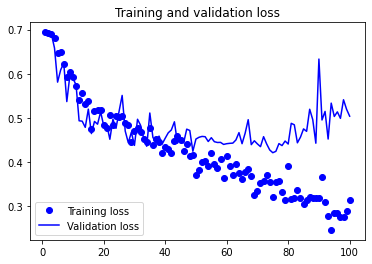

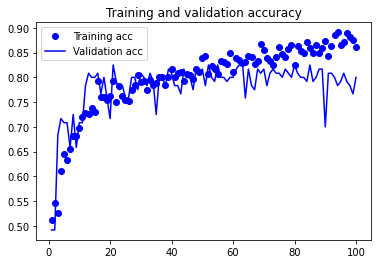

<Figure size 432x288 with 0 Axes>

In [51]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

## Create Confusion matrix

In [52]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [53]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
# Print the label associated with each class
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [56]:
# make a prediction
predictions = model.predict(test_gen, steps=val_steps, verbose=1)

12/12 [==============================] - 0s 17ms/step


In [57]:
predictions.shape

(120, 2)

In [58]:

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [59]:
test_labels.shape

(120,)

In [60]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [61]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Confusion matrix, without normalization
[[54  7]
 [13 46]]


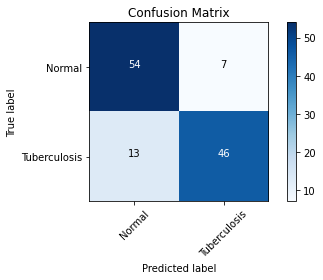

In [62]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [63]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [64]:
from sklearn.metrics import classification_report

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      Normal       0.81      0.89      0.84        61
Tuberculosis       0.87      0.78      0.82        59

    accuracy                           0.83       120
   macro avg       0.84      0.83      0.83       120
weighted avg       0.84      0.83      0.83       120



In [65]:
shutil.rmtree('base_dir')